# Regressão - Concreto com Fibras (com dados injetados)
Notebook com os dados originais injetados em uma célula para execução offline.

In [1]:
# Importações e configurações iniciais (TensorFlow removido para compatibilidade)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# Preferir leitura do Excel local; detectar e pular cabeçalho/meta se necessário
import os
excel_path = os.path.join(os.getcwd(), 'teste banco de dados.xlsx')
if os.path.exists(excel_path):
    # Tentar encontrar a linha do cabeçalho real: procurar a primeira linha com >50% de colunas não-nulas
    candidate = None
    for skip in range(0, 6):
        tmp = pd.read_excel(excel_path, header=skip)
        non_null_ratio = tmp.notna().sum(axis=1).iloc[0] / tmp.shape[1] if tmp.shape[0] > 0 else 0
        # heurística simples: se a primeira linha lida tem pelo menos 20% de valores não-nulos, usamos como header
        if tmp.shape[0] > 0 and non_null_ratio >= 0.2:
            candidate = skip
            break
    if candidate is None:
        # fallback carga básica sem header (use as primeiras linhas como colunas e trate depois)
        df = pd.read_excel(excel_path, header=0)
    else:
        df = pd.read_excel(excel_path, header=candidate)
    print(f'Carregado Excel ({excel_path}) com header skip={candidate if candidate is not None else 0}; shape=', df.shape)
else:
    # Se não houver Excel, comentar injeção e instruir o uso do backup
    # data = {...}  # injeção original comentada para evitar conflito
    raise FileNotFoundError('Arquivo Excel não encontrado. Coloque no diretório do projeto.')

# Normalizar nomes de colunas
df.columns = [str(c).strip().replace('\n', ' ').replace('  ', ' ').replace(' ', '_') for c in df.columns]
print('Colunas detectadas:', list(df.columns))

Carregado Excel (C:\Users\carlos.ramos\OneDrive - Presidência da República\Área de Trabalho\Proj_Cimento\teste banco de dados.xlsx) com header skip=4; shape= (282, 16)
Colunas detectadas: ['Unnamed:_0', 'Unnamed:_1', 'Unnamed:_2', 'Banco_de_dados:_características_da_matriz_e_das_fibras_utilizadas', 'Unnamed:_4', 'Unnamed:_5', 'Unnamed:_6', 'Unnamed:_7', 'Unnamed:_8', 'Unnamed:_9', 'Unnamed:_10', 'Unnamed:_11', 'Unnamed:_12', 'Unnamed:_13', 'Unnamed:_14', 'Unnamed:_15']


In [3]:
# Se preferir usar o Excel local, comente a injeção acima e descomente a leitura abaixo:
# df = pd.read_excel('teste banco de dados.xlsx')
display(df.head())
print('Shape:', df.shape)


,Unnamed:_0,Unnamed:_1,Unnamed:_2,Banco_de_dados:_características_da_matriz_e_das_fibras_utilizadas,Unnamed:_4,Unnamed:_5,Unnamed:_6,Unnamed:_7,Unnamed:_8,Unnamed:_9,Unnamed:_10,Unnamed:_11,Unnamed:_12,Unnamed:_13,Unnamed:_14,Unnamed:_15
0,NaN,NaN,NaN,Tipo do concreto,fck [MPa],l [mm],d [mm],l/d,Teor de fibra (%),N (ganchos),"fR,1 (N/mm²) (experimental)","fR,3 (N/mm²) (experimental)",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,AM-0.4-EH1,61.3,35,0.549969,63.64,0.4,1,4.99,3.32,NaN,4.769909,0.044106,False
2,NaN,NaN,NaN,AM-0.8-EH1,63.8,35,0.549969,63.64,0.8,1,7.44,5.68,NaN,8.025040,0.078634,False
3,NaN,NaN,NaN,AM-0.4-EH2,63.6,60,0.899955,66.67,0.4,1,5.35,5.53,NaN,4.924721,0.079491,False
4,NaN,NaN,NaN,AM-0.8-EH2,58.7,60,0.899955,66.67,0.8,1,7.94,8.78,NaN,7.831532,0.013661,False


Shape: (282, 16)


Coluna alvo escolhida: Unnamed:_14
Features usadas: ['Banco_de_dados:_características_da_matriz_e_das_fibras_utilizadas', 'Unnamed:_4', 'Unnamed:_5', 'Unnamed:_6', 'Unnamed:_7', 'Unnamed:_8', 'Unnamed:_9', 'Unnamed:_10', 'Unnamed:_11', 'Unnamed:_13']
RandomForest - MSE: 0.010928107500128355 MAE: 0.06757253467666925 R2: 0.657995297539051
Ridge  - MSE: 0.023829934459403054 MAE: 0.12266392988497368 R2: 0.25422131468268094

Equação estimada (termos em unidades originais):
y = 0.27679 +0.00112115 * Banco_de_dados:_características_da_matriz_e_das_fibras_utilizadas -0.00341961 * Unnamed:_4 -0.00719404 * Unnamed:_5 +0.386738 * Unnamed:_6 +0.00396853 * Unnamed:_7 -0.465123 * Unnamed:_8 -0.151029 * Unnamed:_9 -0.0691963 * Unnamed:_10 +0.0105307 * Unnamed:_11 +0.113255 * Unnamed:_13

Modelos salvos: model_rf.joblib, model_lr.joblib, scaler_X.joblib


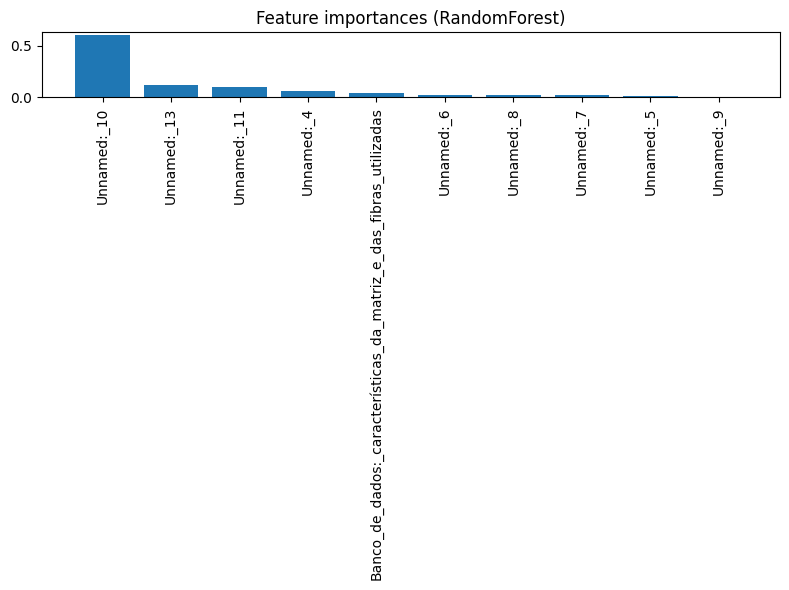

In [4]:
# Treinamento: RandomForest + Regressão linear (equação)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import joblib
import re

# Detectar coluna alvo (procura por fr3, fR3, resistência, etc.)
candidates = [c for c in df.columns if re.search(r'(?i)f\s*r\s*3|fr3|fR3|resist', c)]
if candidates:
    target_col = candidates[0]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        target_col = numeric_cols[-1]
    else:
        raise ValueError('Não foi possível detectar a coluna alvo.')
print('Coluna alvo escolhida:', target_col)

# Converter colunas para numéricas (substitui vírgula decimal e remove texto)
def to_numeric_series(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.').str.replace('[^0-9\.-]', '', regex=True), errors='coerce')

df_num = df.copy()
for c in df.columns:
    df_num[c] = to_numeric_series(df[c])

df_num = df_num.dropna(subset=[target_col])
feature_cols = [c for c in df_num.columns if c != target_col and df_num[c].notna().sum() > 0]
print('Features usadas:', feature_cols)

X = df_num[feature_cols].fillna(df_num[feature_cols].median())
y = df_num[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Treinar RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('RandomForest - MSE:', mse_rf, 'MAE:', mae_rf, 'R2:', r2_rf)

# Treinar Regressão linear com regularização (Ridge) para extrair equação
lr = RidgeCV(alphas=(0.1, 1.0, 10.0))
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print('Ridge  - MSE:', mse_lr, 'MAE:', mae_lr, 'R2:', r2_lr)

# Converter equação para termos das features originais
means = scaler.mean_
scales = scaler.scale_
coef_scaled = lr.coef_
intercept = lr.intercept_

adjusted_coefs = coef_scaled / scales
adjusted_intercept = intercept - (coef_scaled * (means / scales)).sum()

# Formatando equação
terms = [f'{adjusted_coefs[i]:+.6g} * {feature_cols[i]}' for i in range(len(feature_cols))]
equation = f'y = {adjusted_intercept:.6g} ' + ' '.join(terms)
print('\nEquação estimada (termos em unidades originais):')
print(equation)

# Salvar modelos e scaler
joblib.dump(rf, 'model_rf.joblib')
joblib.dump(lr, 'model_lr.joblib')
joblib.dump(scaler, 'scaler_X.joblib')
print('\nModelos salvos: model_rf.joblib, model_lr.joblib, scaler_X.joblib')

# Feature importances (RandomForest)
import matplotlib.pyplot as plt
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8,6))
plt.bar([feature_cols[i] for i in idx], importances[idx])
plt.xticks(rotation=90)
plt.title('Feature importances (RandomForest)')
plt.tight_layout()
plt.show()

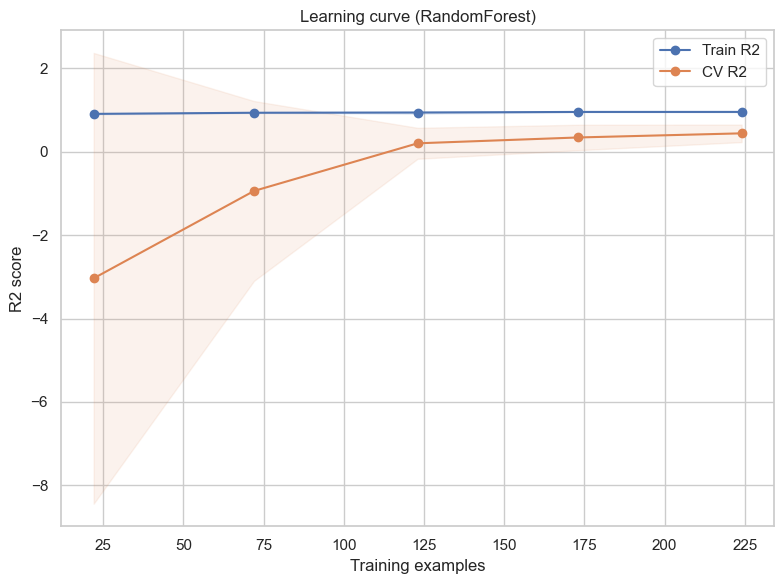

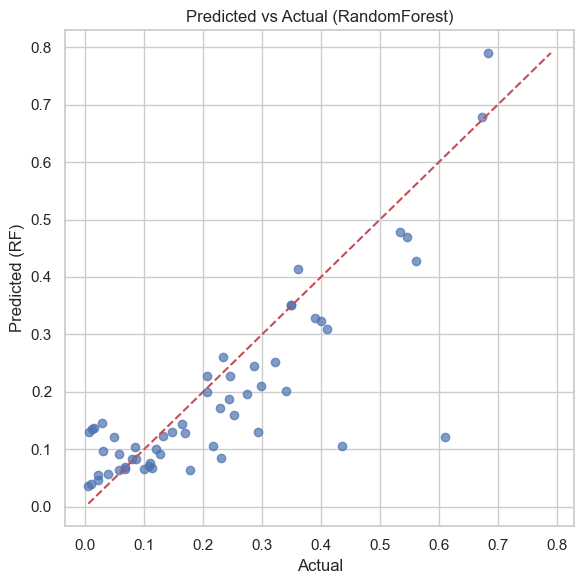

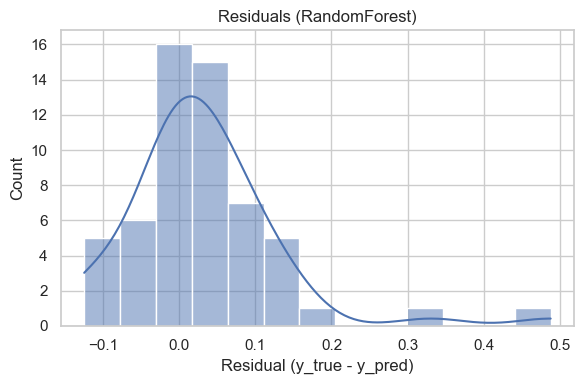

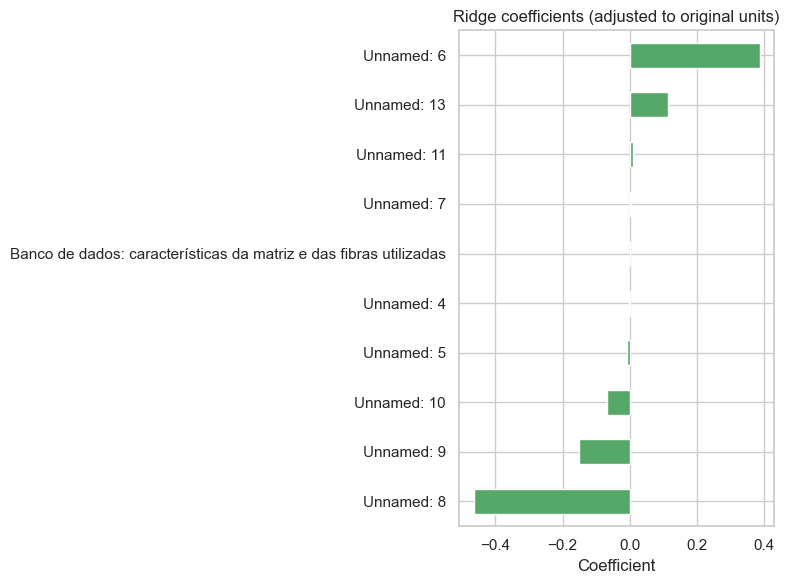

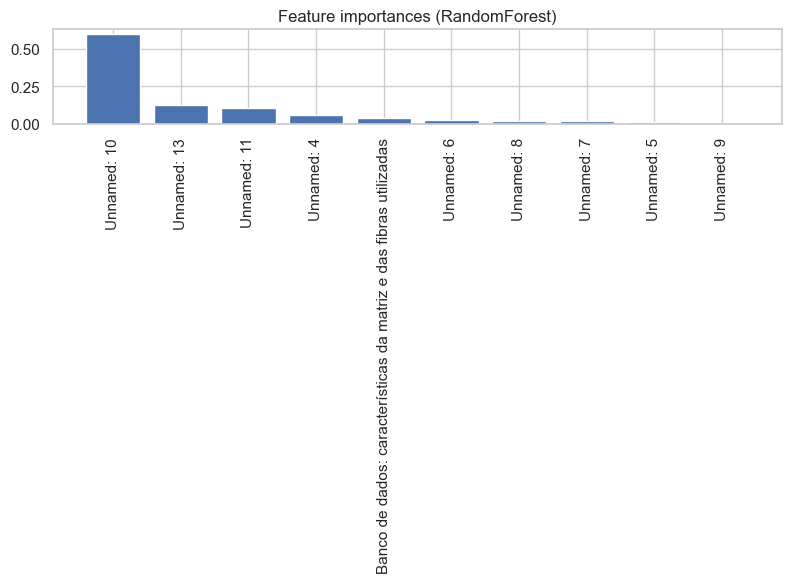

Equação formatada salva em equation.txt
y = 0.27679
 + 0.00112115 * Banco de dados: características da matriz e das fibras utilizadas
 - 0.00341961 * Unnamed: 4
 - 0.00719404 * Unnamed: 5
 + 0.386738 * Unnamed: 6
 + 0.00396853 * Unnamed: 7
 - 0.465123 * Unnamed: 8
 - 0.151029 * Unnamed: 9
 - 0.0691963 * Unnamed: 10
 + 0.0105307 * Unnamed: 11
 + 0.113255 * Unnamed: 13
learning_curve_rf.png -> EXISTS
predicted_vs_actual_rf.png -> EXISTS
residuals_rf.png -> EXISTS
coefficients_ridge.png -> EXISTS
feature_importances_rf.png -> EXISTS
equation.txt -> EXISTS


In [5]:
# Visualizações de treino e formatação da equação (salva imagens e arquivo de texto)
import os
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# 1) Learning curve (R2) para RandomForest
plt.figure(figsize=(8,6))
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color='C0', label='Train R2')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='C0')
plt.plot(train_sizes, test_mean, 'o-', color='C1', label='CV R2')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='C1')
plt.xlabel('Training examples')
plt.ylabel('R2 score')
plt.legend()
plt.title('Learning curve (RandomForest)')
plt.tight_layout()
plt.savefig('learning_curve_rf.png', dpi=150)
plt.show()

# 2) Predicted vs Actual (test set) - RandomForest
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
mn = min(min(y_test), min(y_pred_rf))
mx = max(max(y_test), max(y_pred_rf))
plt.plot([mn,mx],[mn,mx], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted (RF)')
plt.title('Predicted vs Actual (RandomForest)')
plt.tight_layout()
plt.savefig('predicted_vs_actual_rf.png', dpi=150)
plt.show()

# 3) Residuals (test set) - RandomForest
residuals = y_test - y_pred_rf
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual (y_true - y_pred)')
plt.title('Residuals (RandomForest)')
plt.tight_layout()
plt.savefig('residuals_rf.png', dpi=150)
plt.show()

# 4) Coefficients (Ridge) - mostrar como barra e salvar
feat_names = [str(f).replace('_', ' ').strip() for f in feature_cols]
coef_vals = adjusted_coefs
coef_df = pd.Series(coef_vals, index=feat_names).sort_values()
plt.figure(figsize=(8,6))
coef_df.plot(kind='barh', color='C2')
plt.title('Ridge coefficients (adjusted to original units)')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.savefig('coefficients_ridge.png', dpi=150)
plt.show()

# 5) Feature importances já salvas anteriormente; garantir arquivo
try:
    plt.figure(figsize=(8,6))
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1]
    plt.bar([feat_names[i] for i in idx], importances[idx])
    plt.xticks(rotation=90)
    plt.title('Feature importances (RandomForest)')
    plt.tight_layout()
    plt.savefig('feature_importances_rf.png', dpi=150)
    plt.show()
except Exception as e:
    print('Erro ao salvar feature importances:', e)

# 6) Escrever equação formatada em arquivo (uma linha por termo)
nice_terms = []
for i, n in enumerate(feat_names):
    coef = adjusted_coefs[i]
    sign = '+' if coef >= 0 else '-'
    nice_terms.append(f' {sign} {abs(coef):.6g} * {n}')
nice_eq = f'y = {adjusted_intercept:.6g}' + '\n' + '\n'.join(nice_terms)
with open('equation.txt', 'w', encoding='utf-8') as f:
    f.write('Equação estimada (unidades originais):\n')
    f.write(nice_eq)
print('Equação formatada salva em equation.txt')
print(nice_eq)

# Indicar arquivos salvos
files = ['learning_curve_rf.png','predicted_vs_actual_rf.png','residuals_rf.png','coefficients_ridge.png','feature_importances_rf.png','equation.txt']
for fn in files:
    print(fn, '->', 'EXISTS' if os.path.exists(fn) else 'MISSING')


In [6]:
# Plot da equação estimada comparada com RandomForest e renderizar a equação no gráfico
import numpy as np
import matplotlib.pyplot as plt
import os

# Escolher a feature principal pela magnitude do coeficiente ajustado
main_idx = int(np.argmax(np.abs(adjusted_coefs))) if len(adjusted_coefs)>0 else 0
main_feat = feature_cols[main_idx]
print('Feature principal para plot:', main_feat)

# Gerar grid para a feature principal mantendo outras no valor mediano
grid = np.linspace(X[main_feat].min(), X[main_feat].max(), 300)

Feature principal para plot: Unnamed:_8
